# Pre-Processing and Modeling

## Contents

* Pre-Processing and Training Data
    * Introduction
    * Imports 
    * Load Data
    * Outliers
    * Train/Test Split
* Initial Models
    * Metrics
        * R-squared, or coefficient of determination
        * Mean Absolute Error
        * Mean Squared Error
    * Linear Regression model
        * Define the model
        * Fit the model
        * Assess performance on the train and test set
        * Assessing performance using cross validation
        * Hyperparameter search using GridSearchCV
    * ARIMA model
        * Define the model
        * Fit the model
        * $R^2$ 
        * MSE
    * Random Forest Model
        * Define the model
        * fit and assess performance
        * MSE
        * Feature importance
* Conclusion
    

## Introduction

Online retails become one of the biggest aspect of the businesses. Online Retail II dataset contians all the transactions occuring for a UK based and registered, non-store online retail between 12/2010 and 12/2011. The company sells unique all-occasion gift-ware. Most of the buyers are wholesalers. In this notebook, I will build the model that predicts a total sales. 

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import os
from sklearn import utils
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
np.random.seed(0)
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

## Load data

In [2]:
df = pd.read_csv('Cleaned_Data5.csv')

C:\Users\batka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,year,month,day,week,weekday,dayofyear
0,540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,16446.0,United Kingdom,168469.60,2011,12,9,49,4,343
1,61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom,77183.60,2011,1,18,3,1,18
2,421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27,0.21,12901.0,United Kingdom,1008.00,2011,10,27,43,3,300
3,206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27,0.72,13135.0,United Kingdom,3096.00,2011,5,27,21,4,147
4,97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22,0.82,18087.0,United Kingdom,3202.92,2011,2,22,8,1,53


In [4]:
df = df.drop('Unnamed: 0', axis =1).set_index('InvoiceDate')

In [5]:
df1 = df[~df["InvoiceNo"].str.contains("C", na = False)]
df2 = df1[df1['Quantity']>0]
df2 = df2.drop('Description', axis =1)
df5 = df2.drop('StockCode', axis =1)
#df5 = df5[~df5["CustomerID"].str.contains("L", na = False)]
df5 = df5[~df5["InvoiceNo"].str.contains("A", na = False)]

## Outliers

In [6]:
Q1 = df5.TotalPrice.quantile(0.05)
Q3 = df5.TotalPrice.quantile(0.95)
IQR = Q3 - Q1
df5 = df5[(df5.TotalPrice>= Q1-1.5*IQR)&(df5.TotalPrice<=Q3+1.5*IQR)]

In [7]:
Q1 = df5.Quantity.quantile(0.05)
Q3 = df5.Quantity.quantile(0.95)
IQR = Q3 - Q1
df5 = df5[(df5.Quantity>= Q1-1.5*IQR)&(df5.Quantity<=Q3+1.5*IQR)]

## Train Test Split

Time series datasets are little tricky to train test split. We can't split data randomly, so we have to specify train and test data. 

In [8]:
df5=df5.drop('Quantity', axis =1)

In [9]:
df6 = df5[df5.index<='2011-09-31']
df6= df6.drop('Country', axis=1)

In [10]:
df7 = df5[df5.index>='2011-09-31']
df7= df7.drop('Country', axis = 1)

In [11]:
X_train = df6.drop('TotalPrice', axis =1)
X_test = df7.drop('TotalPrice', axis = 1)
y_train = df6.TotalPrice
y_test = df7.TotalPrice

## Initial Models

### Metrics

One measure is $R^2$, the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination). The linked Wikipedia articles gives a nice explanation of how negative values can arise. This is frequently a cause of confusion for newcomers who, reasonably, ask how can a squared value be negative?

Recall the mean can be denoted by $\bar{y}$, where

$$\bar{y} = \frac{1}{n}\sum_{i=1}^ny_i$$

and where $y_i$ are the individual values of the dependent variable.

The total sum of squares (error), can be expressed as

$$SS_{tot} = \sum_i(y_i-\bar{y})^2$$

The above formula should be familiar as it's simply the variance without the denominator to scale (divide) by the sample size.

The residual sum of squares is similarly defined to be

$$SS_{res} = \sum_i(y_i-\hat{y})^2$$

where $\hat{y}$ are our predicted values for the depended variable.

The coefficient of determination, $R^2$, here is given by

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Putting it into words, it's one minus the ratio of the residual variance to the original variance. Thus, the baseline model here, which always predicts $\bar{y}$, should give $R^2=0$. A model that perfectly predicts the observed values would have no residual error and so give $R^2=1$. Models that do worse than predicting the mean will have increased the sum of squares of residuals and so produce a negative $R^2$.

In [12]:
y_pred_train = y_train.mean() * np.ones(len(y_train))
y_pred_test = y_train.mean()*np.ones(len(y_test))

### $R^2$ 

In [13]:
r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)

(0.0, -0.011161633732368115)

### Mean absolute error

In [14]:
mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)

(10.95009484937995, 11.286343598740999)

### Mean squared error

In [15]:
mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)

(333.34966585456226, 307.3760800761407)

## Linear Model Regression

### Define a model 

In [16]:
model= LinearRegression()
model_fit = model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [19]:
print('Mean Squared Error: ', mean_squared_error(y_test, prediction))
print('R squared: ', r2_score(y_test, prediction))

Mean Squared Error:  282.1748870155306
R squared:  0.07174162777340354


C:\Users\batka\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


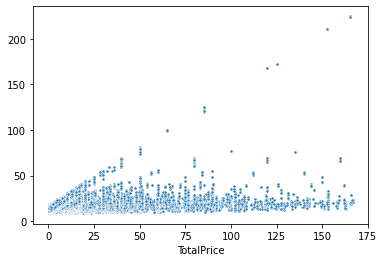

In [20]:
sns.scatterplot(y_test, prediction, marker = ".")

## ARIMA

### Define a Model

In [21]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df5.TotalPrice)

(0.01, False)

In [22]:
from sklearn.model_selection import TimeSeriesSplit

In [23]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(df5.TotalPrice):
     print("TRAIN:", train_index, "TEST:", test_index)

     #To get the indices 
     X_train, X_test = df5.TotalPrice[train_index], df5.TotalPrice[test_index]

TRAIN: [     0      1      2 ... 127356 127357 127358] TEST: [127359 127360 127361 ... 254715 254716 254717]
TRAIN: [     0      1      2 ... 254715 254716 254717] TEST: [254718 254719 254720 ... 382074 382075 382076]


In [ ]:
from pmdarima import auto_arima
model = auto_arima(X_train, supress_warnings=True, trace=True,
                   error_action='ignore')
model.fit(X_train)

forecast = model.predict(n_periods=len(X_test))
forecast = pd.DataFrame(forecast,index = X_test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc = 'Left corner')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2164084.830, Time=120.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2313711.399, Time=4.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2247599.321, Time=9.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2166414.134, Time=49.96 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2313709.399, Time=1.81 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=322.98 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2163488.300, Time=85.90 sec


In [ ]:
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc = 'Left corner')
plt.show()

In [ ]:
forecast.head()

In [ ]:
print(mean_squared_error(X_test, forecast))
print(r2_score(X_test, forecast))

## RandomForestRegressor

### Define a Model

In [ ]:
# split train and test 

X_train = df6.drop('TotalPrice', axis =1)
X_test = df7.drop('TotalPrice', axis = 1)
y_train = df6.TotalPrice
y_test = df7.TotalPrice

In [ ]:
X_train.head()

In [ ]:
model = RandomForestRegressor()
model_fit= model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
print(model_fit.feature_importances_)
X_test.columns

In [ ]:
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
print('R squared: ', r2_score(y_test, y_pred))

## Conclusion

Based on performance, LinearRegression, Arima, and RandomForest models perform not well. The biggest reason is features are doesn’t have any effect on the total sales except for the quantity. The next step is to focus on the customers and countries more. Which country can buy more products and work on customers are in the middle of the pack and bring them up to top buyers. Also, investigate more on why there are many cancellations.


## Result

1. The customer with the highest number of orders comes from the United Kingdom (UK) 
2. The customer with the highest money spent on purchases comes from Netherlands
3. TOP 5 countries (including UK) that place the highest number of orders are as follow → United Kingdom, Germany, France, Ireland (EIRE), Spain
4. As the company receives the highest number of orders from customers in the UK (since it is a UK-based company), customers in the UK spend the most on their purchases. Therefore, the TOP 5 countries (including UK) that spend the most money on purchases are as follow → United Kingdom, Netherlands, Ireland (EIRE), Germany, France
5. November 2011 has the highest sales. The month with the lowest sales is undetermined as the dataset consists of transactions until 9th December 2011 in December
6. There are no transactions on Saturday between 1st Dec 2010 — 9th Dec 2011
7. The number of orders received by the company tends to increases from Monday to Thursday and decrease afterward
8. The company receives the highest number of orders at 12:00pm. Possibly most customers made purchases during lunch hour between 12:00pm — 2:00pm
9. The company tends to give out FREE items for purchases occasionally each month (Except June 2011). However, it is not clear what factors contribute to giving out the FREE items to the particular customers
